In [1]:
#1. Load environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.tsa.regime_switching.markov_switching import MarkovSwitching
from scipy.stats import zscore
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error, r2_score
import pwlf
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from scipy.stats import linregress

In [2]:
#2. Load the data

aer = pd.read_excel('/Users/sandimakhathini/data/aer_tbfg.xlsx', sheet_name=None)
ecta = pd.read_excel('/Users/sandimakhathini/data/ecta_tbfg.xlsx', sheet_name=None)
jpe = pd.read_excel('/Users/sandimakhathini/data/jpe_tbfg.xlsx', sheet_name=None)
qje = pd.read_excel('/Users/sandimakhathini/data/qje_tbfg.xlsx', sheet_name=None)
res = pd.read_excel('/Users/sandimakhathini/data/res_tbfg.xlsx', sheet_name=None)

df = [aer, ecta, jpe, qje, res]

In [3]:
# 2.1 Load additional data for checking whether we have all data points

df_aer = pd.read_excel('/Users/sandimakhathini/data/aer_refs_all.xlsx')
df_ecta = pd.read_excel('/Users/sandimakhathini/data/ecta_refs_all.xlsx')
df_jpe = pd.read_excel('/Users/sandimakhathini/data/jpe_refs_all.xlsx')
df_qje = pd.read_excel('/Users/sandimakhathini/data/qje_refs_all.xlsx')
df_res = pd.read_excel('/Users/sandimakhathini/data/res_refs_all.xlsx')

In [4]:
# AER
# Function to group data by 'id', sum numeric columns, and count unique pages
def group_data_by_id(df, id_col='id', sum_col=None, page_col=None, year_col='year'):
    agg_dict = {}
    if sum_col:
        agg_dict[sum_col] = 'sum'  # Summing the specified column (e.g., fg_count, tb_count)
    if page_col:
        agg_dict[page_col] = 'nunique'  # Counting unique pages
    if year_col:
        agg_dict[year_col] = 'first'  # Keeping the first year (assuming it is the same for all rows with the same 'id')

    return df.groupby(id_col).agg(agg_dict).reset_index()

# Function to convert a column to numeric and rename columns
def convert_and_rename(df, rename_dict):
    df.rename(columns=rename_dict, inplace=True)
    for col in rename_dict.values():
        df[col] = pd.to_numeric(df[col], errors='coerce')  
    return df

# Step 1: Process df_aer and group by 'id'
df_aer_grouped = df_aer.groupby('id').agg({'year': 'first', 'id': 'size'}).rename(columns={'id': 'num_pages'}).reset_index()

# Step 2: Process fg_count from ecta_figures (Sheet 1)
aer_figures = convert_and_rename(aer['fg1940_1970'], {'fg_count': 'fg_count'})
fg_count_grouped = group_data_by_id(aer_figures, sum_col='fg_count')

# Step 3: Merge fg_count with df_ecta_grouped
aer_merged = pd.merge(df_aer_grouped, fg_count_grouped, on='id', how='left')
aer_merged['fg_count'].fillna(0, inplace=True)

# Step 4: Process fg_count from Sheet 3 and merge with df_merged
aer_combined = convert_and_rename(aer['post1970'], {'ID': 'id', 'fg_count': 'fg_count'})
aer_final = pd.merge(aer_merged, aer_combined[['id', 'fg_count']], on='id', how='left', suffixes=('_sheet1', '_sheet3'))
aer_final['fg_count_sheet3'].fillna(0, inplace=True)
aer_final['total_fg_count'] = aer_final['fg_count_sheet1'] + aer_final['fg_count_sheet3']

# Step 5: Process tb_count from ecta_tables (Sheet 2)
aer_tables = convert_and_rename(aer['tb1940_1970'], {'Answer': 'tb_count'})
tb_count_grouped = group_data_by_id(aer_tables, sum_col='tb_count', page_col='page')
aer_final = pd.merge(aer_final, tb_count_grouped[['id', 'tb_count']], on='id', how='left')
aer_final['tb_count'].fillna(0, inplace=True)

# Step 6: Process tb_count from Sheet 3 and merge with df_final_merged
aer_combined = convert_and_rename(aer['post1970'], {'tb_count': 'tb_count'})
aer_final = pd.merge(aer_final, aer_combined[['id', 'tb_count']], on='id', how='left', suffixes=('_sheet2', '_sheet3'))
aer_final['tb_count_sheet3'].fillna(0, inplace=True)
aer_final['total_tb_count'] = aer_final['tb_count_sheet2'] + aer_final['tb_count_sheet3']


/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/3744730656.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  aer_merged['fg_count'].fillna(0, inplace=True)
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/3744730656.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [5]:
# Cleaning up the data set for before analysis
aer_tbfg = aer_final[['id', 'year_x', 'num_pages', 'total_fg_count', 'total_tb_count']].copy()

# Rename columns
aer_tbfg.rename(columns={'year_x': 'year','total_fg_count':'figures','total_tb_count':'tables'}, inplace=True)

# Print 
print(aer_tbfg.head())
print("Number of rows in the final combined dataframe:", len(aer_tbfg))

    id  year  num_pages  figures  tables
0  355  1941         13      0.0     0.0
1  356  1941         13      0.0     0.0
2  357  1941         17      0.0     1.0
3  358  1941         14      0.0     3.0
4  359  1941         18      0.0     1.0
Number of rows in the final combined dataframe: 11138


In [6]:
# AER
# Step 1a: Calculate figures per page for each article
aer_tbfg['figures_per_page'] = aer_tbfg['figures'] / aer_tbfg['num_pages']

# Step 2a: Normalize figures per page across articles per year
normalised_figures_per_year = aer_tbfg.groupby('year').apply(
    lambda x: (x['figures_per_page'].sum()) / len(x)
).reset_index(name='normalised_figures_per_year')

# Step 3a: Normalize figures by the number of articles published per year
total_figures_per_year = aer_tbfg.groupby('year')['figures'].sum().reset_index(name='total_figures')
articles_per_year = aer_tbfg.groupby('year').size().reset_index(name='total_articles')
figures_data = pd.merge(total_figures_per_year, articles_per_year, on='year')
figures_data['figures_normalised_by_articles'] = figures_data['total_figures'] / figures_data['total_articles']

# Step 1b: Calculate tables per page for each article
aer_tbfg['tables_per_page'] = aer_tbfg['tables'] / aer_tbfg['num_pages']

# Step 2b: Normalize tables per page across articles per year
normalised_tables_per_year = aer_tbfg.groupby('year').apply(
    lambda x: (x['tables_per_page'].sum()) / len(x)
).reset_index(name='normalised_tables_per_year')

# Step 3b: Normalize tables by the number of articles published per year
total_tables_per_year = aer_tbfg.groupby('year')['tables'].sum().reset_index(name='total_tables')
tables_data = pd.merge(total_tables_per_year, articles_per_year, on='year')
tables_data['tables_normalised_by_articles'] = tables_data['total_tables'] / tables_data['total_articles']

# Combine all data into a single dataframe
aer_final = pd.merge(figures_data, tables_data, on=['year', 'total_articles'], how='outer')

# Merge normalized figures and tables per year
aer_final = pd.merge(aer_final, normalised_figures_per_year, on='year', how='outer')
aer_final = pd.merge(aer_final, normalised_tables_per_year, on='year', how='outer')

# Display the final combined dataframe
print(aer_final.head())


   year  total_figures  total_articles  figures_normalised_by_articles  \
0  1940           23.0             113                        0.203540   
1  1941           50.0             105                        0.476190   
2  1942           39.0             103                        0.378641   
3  1943           18.0             110                        0.163636   
4  1944           15.0              92                        0.163043   

   total_tables  tables_normalised_by_articles  normalised_figures_per_year  \
0          48.0                       0.424779                     0.023663   
1          59.0                       0.561905                     0.045603   
2          66.0                       0.640777                     0.023091   
3          27.0                       0.245455                     0.018325   
4          84.0                       0.913043                     0.015241   

   normalised_tables_per_year  
0                    0.046744  
1               

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/1599858454.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_figures_per_year = aer_tbfg.groupby('year').apply(
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/1599858454.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_tables_per_year = aer_tbfg.groupby('year').apply(


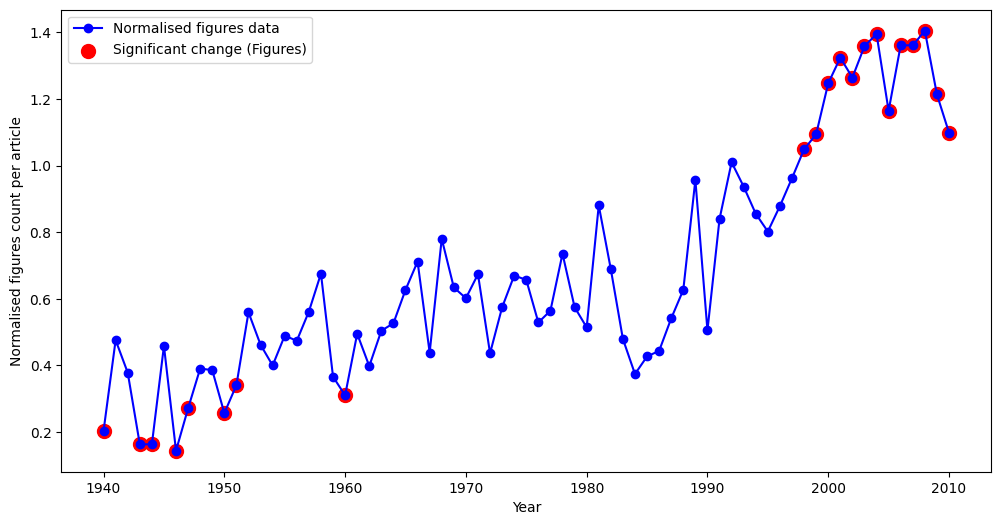

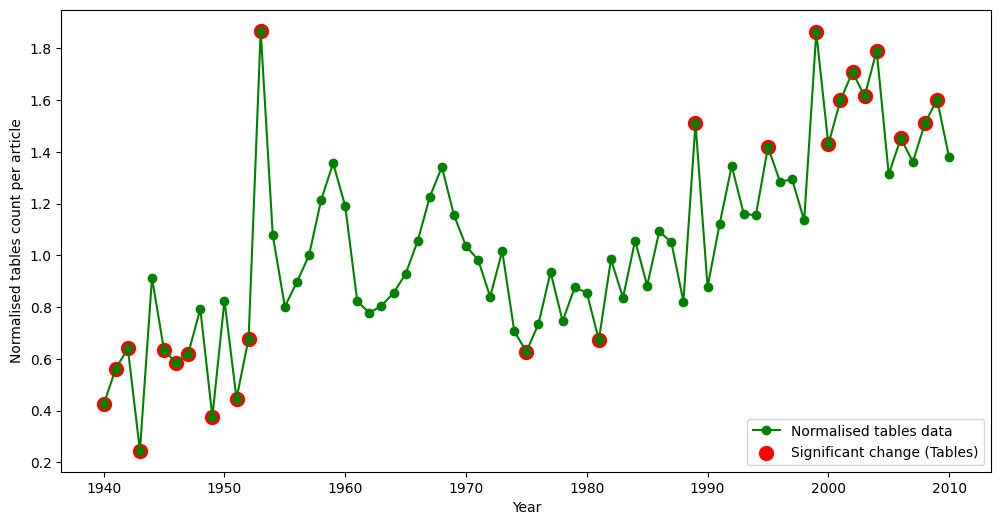

In [7]:
# Calculate the Z-scores for the proportions
aer_final['figures_zscore'] = zscore(aer_final['figures_normalised_by_articles'])
aer_final['tables_zscore'] = zscore(aer_final['tables_normalised_by_articles'])

# Set the threshold for significant years (e.g., Z-scores > 1)
threshold = 1

# Select significant years where Z-scores exceed the threshold for figures
significant_years_figures = aer_final[aer_final['figures_zscore'].abs() > threshold]

# Select significant years where Z-scores exceed the threshold for tables
significant_years_tables = aer_final[aer_final['tables_zscore'].abs() > threshold]

# Plotting the proportion of figures per page over the years
plt.figure(figsize=(12, 6))
plt.plot(aer_final['year'], aer_final['figures_normalised_by_articles'], marker='o', label='Normalised figures data', color='blue')

# Highlight the significant years for figures
plt.scatter(significant_years_figures['year'], significant_years_figures['figures_normalised_by_articles'], color='red', label='Significant change (Figures)', s=100)

plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()
plt.grid(False)
plt.show()

# Plotting the proportion of tables per page over the years
plt.figure(figsize=(12, 6))
plt.plot(aer_final['year'], aer_final['tables_normalised_by_articles'], marker='o', label='Normalised tables data', color='green')

# Highlight the significant years for tables
plt.scatter(significant_years_tables['year'], significant_years_tables['tables_normalised_by_articles'], color='red', label='Significant change (Tables)', s=100)
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.grid(False)
plt.show()

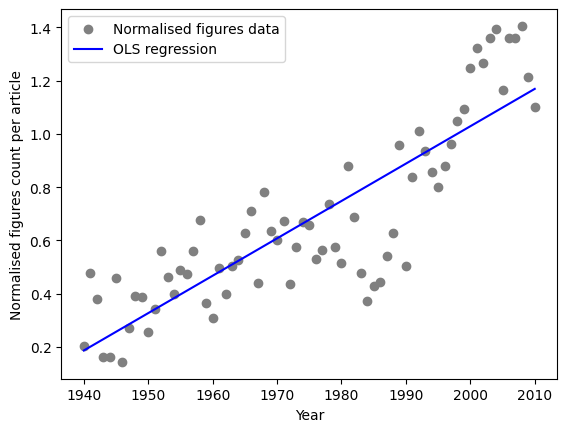

OLS Coefficient (Slope): 0.0140
OLS Intercept: 0.1870


In [8]:
# Figures
# Define your data with centered year
X = np.array(aer_final['year'] - 1940).reshape(-1, 1)  # Center year at 1940
y = np.array(aer_final['figures_normalised_by_articles'])

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)  

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, y, color='grey', label='Normalised figures data')

# Plot the OLS regression line
plt.plot(X +1940, y_pred_ols, color='blue', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()

# Display the plot
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [9]:
# Define your data
X = np.array(aer_final['year'] - 1940).reshape(-1, 1)  
y = np.array(aer_final['figures_normalised_by_articles'])   

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  # Adds a column of ones to include an intercept in the model

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the summary statistics
print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     187.8
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           2.27e-21
Time:                        11:45:35   Log-Likelihood:                 23.310
No. Observations:                  71   AIC:                            -42.62
Df Residuals:                      69   BIC:                            -38.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1870      0.042      4.505      0.0

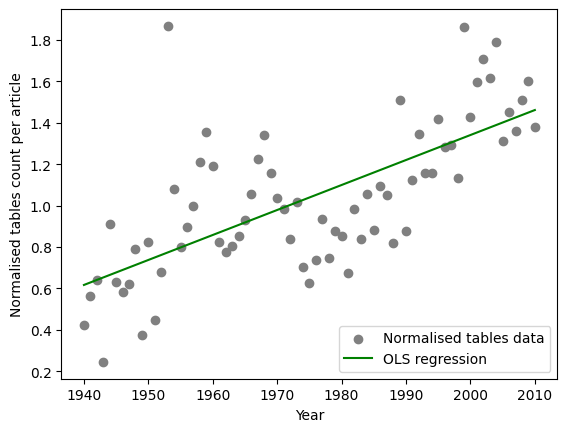

OLS Coefficient (Slope): 0.0121
OLS Intercept: 0.6171


In [10]:
# Tables
# Define your data
X = np.array(aer_final['year']- 1940).reshape(-1, 1)  
z = np.array(aer_final['tables_normalised_by_articles'])  

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, z)  

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, z, color='grey', label='Normalised tables data')

# Plot the OLS regression line
plt.plot(X + 1940, z_pred_ols, color='green', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [11]:
# Define your data
X = np.array(aer_final['year']- 1940).reshape(-1, 1)  
z = np.array(aer_final['tables_normalised_by_articles'])  

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(z, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = z - z_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(z, z_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     61.31
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           4.08e-11
Time:                        11:45:35   Log-Likelihood:                -5.7361
No. Observations:                  71   AIC:                             15.47
Df Residuals:                      69   BIC:                             20.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6171      0.063      9.874      0.0

In [12]:
# ECTA
# Function to group data by 'id', sum numeric columns, and count unique pages
def group_data_by_id(df, id_col='id', sum_col=None, page_col=None, year_col='year'):
    agg_dict = {}
    if sum_col:
        agg_dict[sum_col] = 'sum'  # Summing the specified column (e.g., fg_count, tb_count)
    if page_col:
        agg_dict[page_col] = 'nunique'  # Counting unique pages
    if year_col:
        agg_dict[year_col] = 'first'  # Keeping the first year (assuming it is the same for all rows with the same 'id')

    return df.groupby(id_col).agg(agg_dict).reset_index()

# Function to convert a column to numeric and rename columns
def convert_and_rename(df, rename_dict):
    df.rename(columns=rename_dict, inplace=True)
    for col in rename_dict.values():
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    return df

# Step 1: Process df_ecta and group by 'id'
df_ecta_grouped = df_ecta.groupby('id').agg({'year': 'first', 'id': 'size'}).rename(columns={'id': 'num_pages'}).reset_index()

# Step 2: Process fg_count from ecta_figures (Sheet 1)
ecta_figures = convert_and_rename(ecta['fg1940_1970'], {'fg_count': 'fg_count'})
fg_count_grouped = group_data_by_id(ecta_figures, sum_col='fg_count')

# Step 3: Merge fg_count with df_ecta_grouped
ecta_merged = pd.merge(df_ecta_grouped, fg_count_grouped, on='id', how='left')
ecta_merged['fg_count'].fillna(0, inplace=True)

# Step 4: Process fg_count from Sheet 3 and merge with df_merged
ecta_combined = convert_and_rename(ecta['post1970'], {'ID': 'id', 'fg_count': 'fg_count'})
ecta_final = pd.merge(ecta_merged, ecta_combined[['id', 'fg_count']], on='id', how='left', suffixes=('_sheet1', '_sheet3'))
ecta_final['fg_count_sheet3'].fillna(0, inplace=True)
ecta_final['total_fg_count'] = ecta_final['fg_count_sheet1'] + ecta_final['fg_count_sheet3']

# Step 5: Process tb_count from ecta_tables (Sheet 2)
ecta_tables = convert_and_rename(ecta['tb1940_1970'], {'Answer': 'tb_count'})
tb_count_grouped = group_data_by_id(ecta_tables, sum_col='tb_count', page_col='page')
ecta_final = pd.merge(ecta_final, tb_count_grouped[['id', 'tb_count']], on='id', how='left')
ecta_final['tb_count'].fillna(0, inplace=True)

# Step 6: Process tb_count from Sheet 3 and merge with df_final_merged
ecta_combined = convert_and_rename(ecta['post1970'], {'tb_count': 'tb_count'})
ecta_final = pd.merge(ecta_final, ecta_combined[['id', 'tb_count']], on='id', how='left', suffixes=('_sheet2', '_sheet3'))
ecta_final['tb_count_sheet3'].fillna(0, inplace=True)
ecta_final['total_tb_count'] = ecta_final['tb_count_sheet2'] + ecta_final['tb_count_sheet3']

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/172970562.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ecta_merged['fg_count'].fillna(0, inplace=True)
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/172970562.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

In [13]:
# Cleaning up the data set for before analysis
ecta_tbfg = ecta_final[['id', 'year_x', 'num_pages', 'total_fg_count', 'total_tb_count']].copy()

# Rename columns
ecta_tbfg.rename(columns={'year_x': 'year','total_fg_count':'figures','total_tb_count':'tables'}, inplace=True)

# Print 
print(ecta_tbfg.head())
print("Number of rows in the final combined dataframe:", len(ecta_tbfg))

        id  year  num_pages  figures  tables
0  1555488  2003         38      0.0     7.0
1  1555489  2003         22      4.0     4.0
2  1555490  2003         34      0.0     1.0
3  1555491  2003         37      0.0     0.0
4  1555492  2003         39      0.0     7.0
Number of rows in the final combined dataframe: 4245


In [14]:
# ECTA
# Step 1a: Calculate figures per page for each article
ecta_tbfg['figures_per_page'] = ecta_tbfg['figures'] / ecta_tbfg['num_pages']

# Step 2a: Normalize figures per page across articles per year
normalised_figures_per_year = ecta_tbfg.groupby('year').apply(
    lambda x: (x['figures_per_page'].sum()) / len(x)
).reset_index(name='normalised_figures_per_year')

# Step 3a: Normalize figures by the number of articles published per year
total_figures_per_year = ecta_tbfg.groupby('year')['figures'].sum().reset_index(name='total_figures')
articles_per_year = ecta_tbfg.groupby('year').size().reset_index(name='total_articles')
figures_data = pd.merge(total_figures_per_year, articles_per_year, on='year')
figures_data['figures_normalised_by_articles'] = figures_data['total_figures'] / figures_data['total_articles']

# Step 1b: Calculate tables per page for each article
ecta_tbfg['tables_per_page'] = ecta_tbfg['tables'] / ecta_tbfg['num_pages']

# Step 2b: Normalize tables per page across articles per year
normalised_tables_per_year = ecta_tbfg.groupby('year').apply(
    lambda x: (x['tables_per_page'].sum()) / len(x)
).reset_index(name='normalised_tables_per_year')

# Step 3b: Normalize tables by the number of articles published per year
total_tables_per_year = ecta_tbfg.groupby('year')['tables'].sum().reset_index(name='total_tables')
tables_data = pd.merge(total_tables_per_year, articles_per_year, on='year')
tables_data['tables_normalised_by_articles'] = tables_data['total_tables'] / tables_data['total_articles']

# Combine all data into a single dataframe
ecta_final = pd.merge(figures_data, tables_data, on=['year', 'total_articles'], how='outer')

# Merge normalized figures and tables per year
ecta_final = pd.merge(ecta_final, normalised_figures_per_year, on='year', how='outer')
ecta_final = pd.merge(ecta_final, normalised_tables_per_year, on='year', how='outer')

# Display the final combined dataframe
print(ecta_final.head())


   year  total_figures  total_articles  figures_normalised_by_articles  \
0  1940           29.0              22                        1.318182   
1  1941           14.0              20                        0.700000   
2  1942           10.0              21                        0.476190   
3  1943           14.0              23                        0.608696   
4  1944           23.0              19                        1.210526   

   total_tables  tables_normalised_by_articles  normalised_figures_per_year  \
0          20.0                       0.909091                     0.116949   
1           8.0                       0.400000                     0.048969   
2          11.0                       0.523810                     0.021429   
3           8.0                       0.347826                     0.033949   
4          39.0                       2.052632                     0.074895   

   normalised_tables_per_year  
0                    0.046416  
1               

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/3410803618.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_figures_per_year = ecta_tbfg.groupby('year').apply(
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/3410803618.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_tables_per_year = ecta_tbfg.groupby('year').apply(


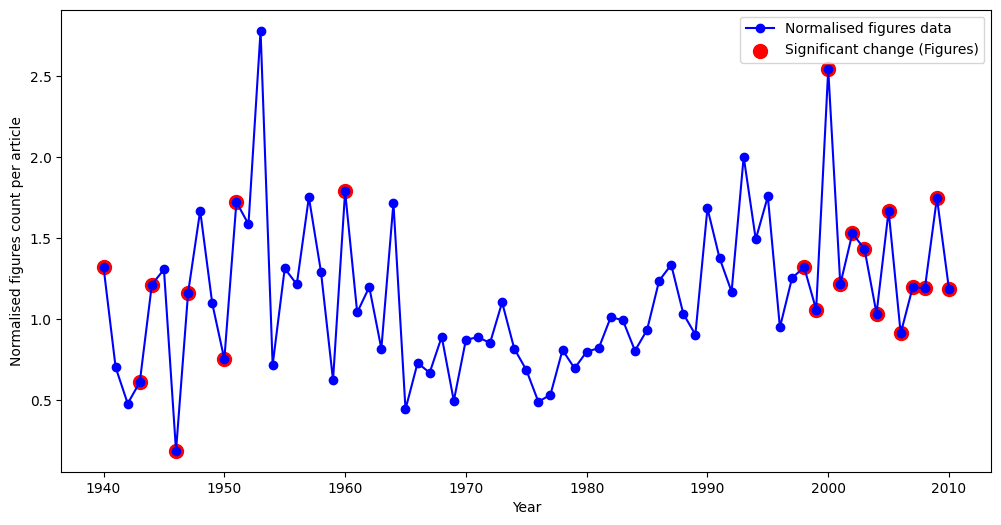

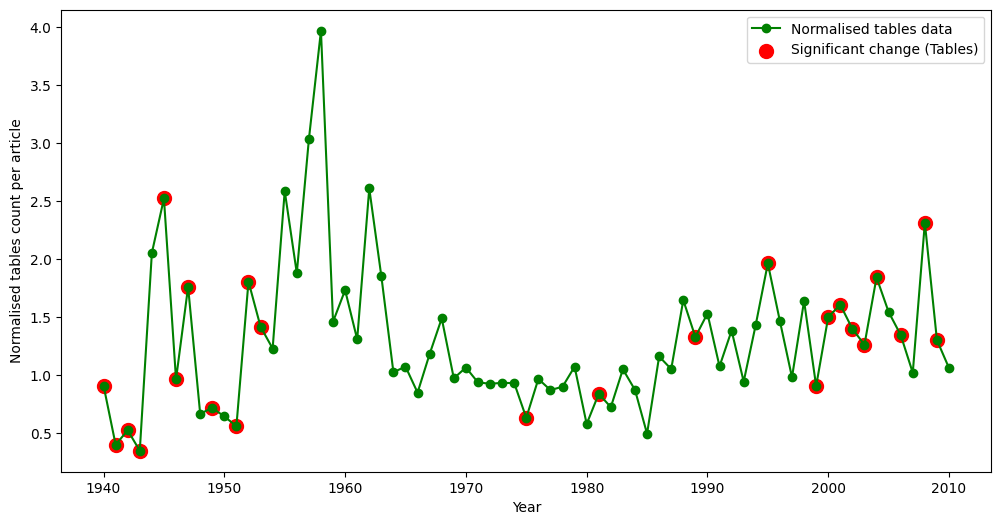

In [15]:
# Calculate the Z-scores for the proportions
ecta_final['figures_zscore'] = zscore(ecta_final['figures_normalised_by_articles'])
ecta_final['tables_zscore'] = zscore(ecta_final['tables_normalised_by_articles'])

# Set the threshold for significant years (e.g., Z-scores > 1)
threshold = 1

# Select significant years where Z-scores exceed the threshold for figures
significant_years_figures = ecta_final[aer_final['figures_zscore'].abs() > threshold]

# Select significant years where Z-scores exceed the threshold for tables
significant_years_tables = ecta_final[aer_final['tables_zscore'].abs() > threshold]

# Plotting the proportion of figures per page over the years
plt.figure(figsize=(12, 6))
plt.plot(ecta_final['year'], ecta_final['figures_normalised_by_articles'], marker='o', label='Normalised figures data', color='blue')

# Highlight the significant years for figures
plt.scatter(significant_years_figures['year'], significant_years_figures['figures_normalised_by_articles'], color='red', label='Significant change (Figures)', s=100)

plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()
plt.grid(False)
plt.show()

# Plotting the proportion of tables per page over the years
plt.figure(figsize=(12, 6))
plt.plot(ecta_final['year'], ecta_final['tables_normalised_by_articles'], marker='o', label='Normalised tables data', color='green')

# Highlight the significant years for tables
plt.scatter(significant_years_tables['year'], significant_years_tables['tables_normalised_by_articles'], color='red', label='Significant change (Tables)', s=100)
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.grid(False)
plt.show()

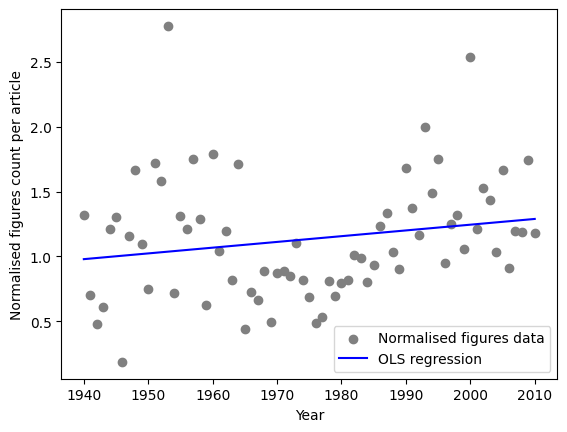

OLS Coefficient (Slope): 0.0044
OLS Intercept: 0.9782


In [16]:
# Figures
# Define your data with centered year
X = np.array(ecta_final['year'] - 1940).reshape(-1, 1)  # Center year at 1940
y = np.array(ecta_final['figures_normalised_by_articles'])

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)  

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, y, color='grey', label='Normalised figures data')

# Plot the OLS regression line
plt.plot(X +1940, y_pred_ols, color='blue', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()

# Display the plot
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [17]:
# Define your data
X = np.array(ecta_final['year'] - 1940).reshape(-1, 1)  
y = np.array(ecta_final['figures_normalised_by_articles'])   

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  # Adds a column of ones to include an intercept in the model

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the summary statistics
print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.726
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.103
Time:                        11:45:36   Log-Likelihood:                -45.141
No. Observations:                  71   AIC:                             94.28
Df Residuals:                      69   BIC:                             98.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9782      0.109      8.985      0.0

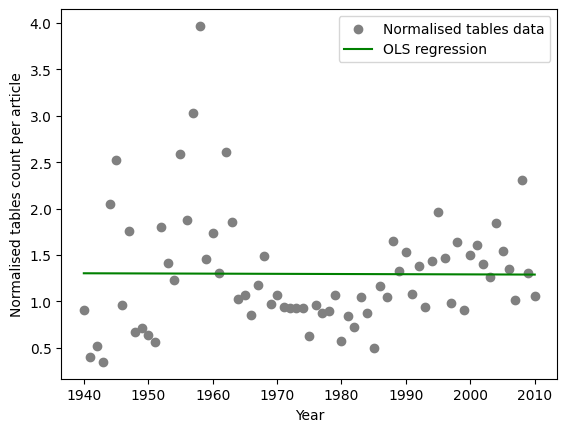

OLS Coefficient (Slope): -0.0002
OLS Intercept: 1.3029


In [18]:
# Tables
# Define your data
X = np.array(ecta_final['year']- 1940).reshape(-1, 1)  
z = np.array(ecta_final['tables_normalised_by_articles'])  

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, z)  

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, z, color='grey', label='Normalised tables data')

# Plot the OLS regression line
plt.plot(X + 1940, z_pred_ols, color='green', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [19]:
# Define your data
X = np.array(ecta_final['year']- 1940).reshape(-1, 1)  
z = np.array(ecta_final['tables_normalised_by_articles'])  

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(z, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = z - z_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(z, z_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                  0.002941
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.957
Time:                        11:45:36   Log-Likelihood:                -67.891
No. Observations:                  71   AIC:                             139.8
Df Residuals:                      69   BIC:                             144.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3029      0.150      8.686      0.0

In [20]:
# JPE
# Function to group data by 'id', sum numeric columns, and count unique pages
def group_data_by_id(df, id_col='id', sum_col=None, page_col=None, year_col='year'):
    agg_dict = {}
    if sum_col:
        agg_dict[sum_col] = 'sum'  # Summing the specified column (e.g., fg_count, tb_count)
    if page_col:
        agg_dict[page_col] = 'nunique'  # Counting unique pages
    if year_col:
        agg_dict[year_col] = 'first'  # Keeping the first year (assuming it is the same for all rows with the same 'id')

    return df.groupby(id_col).agg(agg_dict).reset_index()

# Function to convert a column to numeric and rename columns
def convert_and_rename(df, rename_dict):
    df.rename(columns=rename_dict, inplace=True)
    for col in rename_dict.values():
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    return df

# Step 1: Process df_ecta and group by 'id'
df_jpe_grouped = df_jpe.groupby('id').agg({'year': 'first', 'id': 'size'}).rename(columns={'id': 'num_pages'}).reset_index()

# Step 2: Process fg_count from ecta_figures (Sheet 1)
jpe_figures = convert_and_rename(jpe['fg1940_1970'], {'fg_count': 'fg_count'})
fg_count_grouped = group_data_by_id(jpe_figures, sum_col='fg_count')

# Step 3: Merge fg_count with df_ecta_grouped
jpe_merged = pd.merge(df_jpe_grouped, fg_count_grouped, on='id', how='left')
jpe_merged['fg_count'].fillna(0, inplace=True)

# Step 4: Process fg_count from Sheet 3 and merge with df_merged
jpe_combined = convert_and_rename(jpe['post1970'], {'ID': 'id', 'fg_count': 'fg_count'})
jpe_final = pd.merge(jpe_merged, jpe_combined[['id', 'fg_count']], on='id', how='left', suffixes=('_sheet1', '_sheet3'))
jpe_final['fg_count_sheet3'].fillna(0, inplace=True)
jpe_final['total_fg_count'] = jpe_final['fg_count_sheet1'] + jpe_final['fg_count_sheet3']

# Step 5: Process tb_count from ecta_tables (Sheet 2)
jpe_tables = convert_and_rename(jpe['tb1940_1970'], {'Answer': 'tb_count'})
tb_count_grouped = group_data_by_id(jpe_tables, sum_col='tb_count', page_col='page')
jpe_final = pd.merge(jpe_final, tb_count_grouped[['id', 'tb_count']], on='id', how='left')
jpe_final['tb_count'].fillna(0, inplace=True)

# Step 6: Process tb_count from Sheet 3 and merge with df_final_merged
jpe_combined = convert_and_rename(jpe['post1970'], {'tb_count': 'tb_count'})
jpe_final = pd.merge(jpe_final, jpe_combined[['id', 'tb_count']], on='id', how='left', suffixes=('_sheet2', '_sheet3'))
jpe_final['tb_count_sheet3'].fillna(0, inplace=True)
jpe_final['total_tb_count'] = jpe_final['tb_count_sheet2'] + jpe_final['tb_count_sheet3']

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/1861970462.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  jpe_merged['fg_count'].fillna(0, inplace=True)
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/1861970462.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [21]:
# Cleaning up the data set for before analysis
jpe_tbfg = jpe_final[['id', 'year_x', 'num_pages', 'total_fg_count', 'total_tb_count']].copy()

# Rename columns
jpe_tbfg.rename(columns={'year_x': 'year','total_fg_count':'figures','total_tb_count':'tables'}, inplace=True)

# Print 
print(jpe_tbfg.head())
print("Number of rows in the final combined dataframe:", len(jpe_tbfg))

       id  year  num_pages  figures  tables
0  250001  1998         40      1.0     0.0
1  250002  1998         23      1.0     0.0
2  250003  1998         40      0.0     0.0
3  250004  1998         43      0.0    14.0
4  250005  1998         25      3.0     8.0
Number of rows in the final combined dataframe: 4122


In [22]:
# JPE
# Step 1a: Calculate figures per page for each article
jpe_tbfg['figures_per_page'] = jpe_tbfg['figures'] / jpe_tbfg['num_pages']

# Step 2a: Normalize figures per page across articles per year
normalised_figures_per_year = jpe_tbfg.groupby('year').apply(
    lambda x: (x['figures_per_page'].sum()) / len(x)
).reset_index(name='normalised_figures_per_year')

# Step 3a: Normalize figures by the number of articles published per year
total_figures_per_year = jpe_tbfg.groupby('year')['figures'].sum().reset_index(name='total_figures')
articles_per_year = jpe_tbfg.groupby('year').size().reset_index(name='total_articles')
figures_data = pd.merge(total_figures_per_year, articles_per_year, on='year')
figures_data['figures_normalised_by_articles'] = figures_data['total_figures'] / figures_data['total_articles']

# Step 1b: Calculate tables per page for each article
jpe_tbfg['tables_per_page'] = jpe_tbfg['tables'] / jpe_tbfg['num_pages']

# Step 2b: Normalize tables per page across articles per year
normalised_tables_per_year = jpe_tbfg.groupby('year').apply(
    lambda x: (x['tables_per_page'].sum()) / len(x)
).reset_index(name='normalised_tables_per_year')

# Step 3b: Normalize tables by the number of articles published per year
total_tables_per_year = jpe_tbfg.groupby('year')['tables'].sum().reset_index(name='total_tables')
tables_data = pd.merge(total_tables_per_year, articles_per_year, on='year')
tables_data['tables_normalised_by_articles'] = tables_data['total_tables'] / tables_data['total_articles']

# Combine all data into a single dataframe
jpe_final = pd.merge(figures_data, tables_data, on=['year', 'total_articles'], how='outer')

# Merge normalized figures and tables per year
jpe_final = pd.merge(jpe_final, normalised_figures_per_year, on='year', how='outer')
jpe_final = pd.merge(jpe_final, normalised_tables_per_year, on='year', how='outer')

# Display the final combined dataframe
print(jpe_final.head())


   year  total_figures  total_articles  figures_normalised_by_articles  \
0  1940           37.0              43                        0.860465   
1  1941           15.0              35                        0.428571   
2  1942           57.0              38                        1.500000   
3  1943           12.0              41                        0.292683   
4  1944           17.0              21                        0.809524   

   total_tables  tables_normalised_by_articles  normalised_figures_per_year  \
0          49.0                       1.139535                     0.044072   
1          16.0                       0.457143                     0.033578   
2          51.0                       1.342105                     0.075308   
3          27.0                       0.658537                     0.036632   
4           7.0                       0.333333                     0.037320   

   normalised_tables_per_year  
0                    0.066132  
1               

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/2622886166.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_figures_per_year = jpe_tbfg.groupby('year').apply(
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/2622886166.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_tables_per_year = jpe_tbfg.groupby('year').apply(


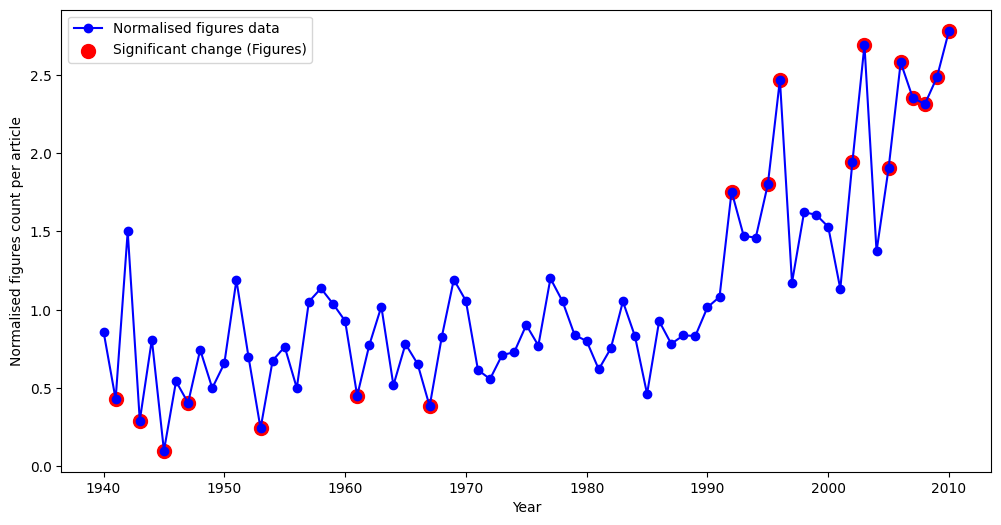

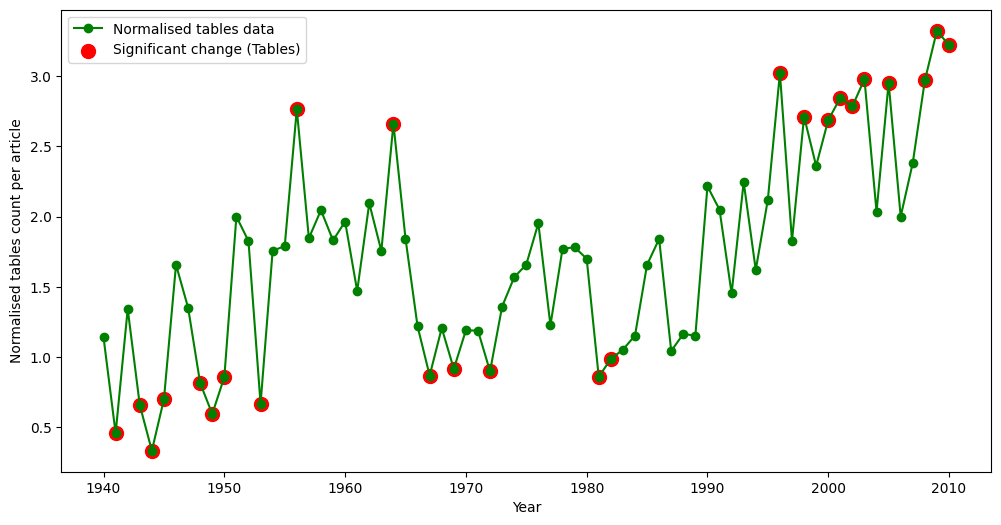

In [23]:
# Calculate the Z-scores for the proportions
jpe_final['figures_zscore'] = zscore(jpe_final['figures_normalised_by_articles'])
jpe_final['tables_zscore'] = zscore(jpe_final['tables_normalised_by_articles'])

# Set the threshold for significant years (e.g., Z-scores > 1)
threshold = 1

# Select significant years where Z-scores exceed the threshold for figures
significant_years_figures = jpe_final[jpe_final['figures_zscore'].abs() > threshold]

# Select significant years where Z-scores exceed the threshold for tables
significant_years_tables = jpe_final[jpe_final['tables_zscore'].abs() > threshold]

# Plotting the proportion of figures per page over the years
plt.figure(figsize=(12, 6))
plt.plot(jpe_final['year'], jpe_final['figures_normalised_by_articles'], marker='o', label='Normalised figures data', color='blue')

# Highlight the significant years for figures
plt.scatter(significant_years_figures['year'], significant_years_figures['figures_normalised_by_articles'], color='red', label='Significant change (Figures)', s=100)

plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()
plt.grid(False)
plt.show()

# Plotting the proportion of tables per page over the years
plt.figure(figsize=(12, 6))
plt.plot(jpe_final['year'], jpe_final['tables_normalised_by_articles'], marker='o', label='Normalised tables data', color='green')

# Highlight the significant years for tables
plt.scatter(significant_years_tables['year'], significant_years_tables['tables_normalised_by_articles'], color='red', label='Significant change (Tables)', s=100)
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.grid(False)
plt.show()

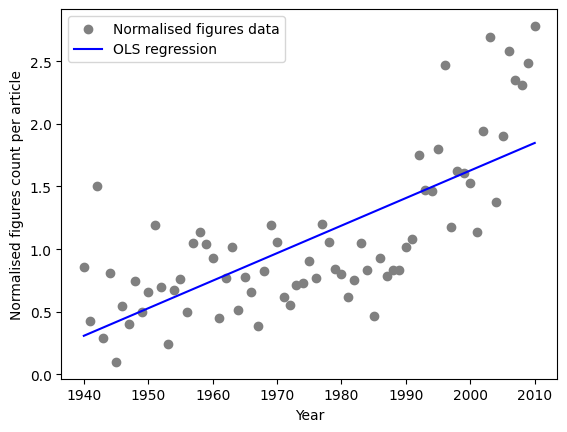

OLS Coefficient (Slope): 0.0220
OLS Intercept: 0.3085


In [24]:
# Figures
# Define your data with centered year
X = np.array(jpe_final['year'] - 1940).reshape(-1, 1)  # Center year at 1940
y = np.array(jpe_final['figures_normalised_by_articles'])

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)  

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, y, color='grey', label='Normalised figures data')

# Plot the OLS regression line
plt.plot(X +1940, y_pred_ols, color='blue', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()

# Display the plot
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [25]:
# Define your data
X = np.array(jpe_final['year'] - 1940).reshape(-1, 1)  
y = np.array(jpe_final['figures_normalised_by_articles'])   

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  # Adds a column of ones to include an intercept in the model

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the summary statistics
print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     78.03
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           6.00e-13
Time:                        11:45:36   Log-Likelihood:                -39.772
No. Observations:                  71   AIC:                             83.54
Df Residuals:                      69   BIC:                             88.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3085      0.101      3.056      0.0

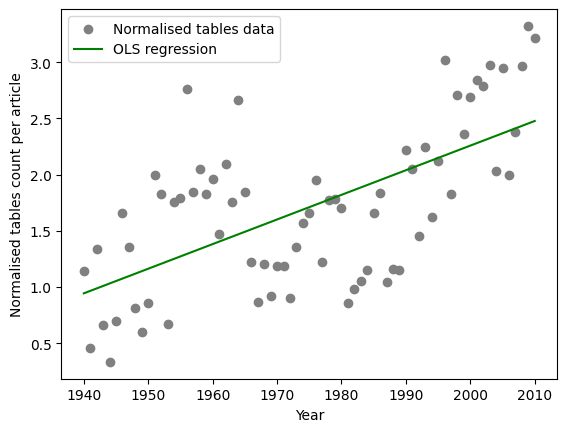

OLS Coefficient (Slope): 0.0219
OLS Intercept: 0.9435


In [26]:
# Tables
# Define your data
X = np.array(jpe_final['year']- 1940).reshape(-1, 1)  
z = np.array(jpe_final['tables_normalised_by_articles'])  

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, z)  

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, z, color='grey', label='Normalised tables data')

# Plot the OLS regression line
plt.plot(X + 1940, z_pred_ols, color='green', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [27]:
# Define your data
X = np.array(jpe_final['year']- 1940).reshape(-1, 1)  
z = np.array(jpe_final['tables_normalised_by_articles'])  

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(z, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = z - z_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(z, z_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     43.80
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           6.49e-09
Time:                        11:45:36   Log-Likelihood:                -60.012
No. Observations:                  71   AIC:                             124.0
Df Residuals:                      69   BIC:                             128.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9435      0.134      7.028      0.0

In [28]:
# QJE
# Function to group data by 'id', sum numeric columns, and count unique pages
def group_data_by_id(df, id_col='id', sum_col=None, page_col=None, year_col='year'):
    agg_dict = {}
    if sum_col:
        agg_dict[sum_col] = 'sum'  # Summing the specified column (e.g., fg_count, tb_count)
    if page_col:
        agg_dict[page_col] = 'nunique'  # Counting unique pages
    if year_col:
        agg_dict[year_col] = 'first'  # Keeping the first year (assuming it is the same for all rows with the same 'id')

    return df.groupby(id_col).agg(agg_dict).reset_index()

# Function to convert a column to numeric and rename columns
def convert_and_rename(df, rename_dict):
    df.rename(columns=rename_dict, inplace=True)
    for col in rename_dict.values():
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    return df

# Step 1: Process df_ecta and group by 'id'
df_qje_grouped = df_qje.groupby('id').agg({'year': 'first', 'id': 'size'}).rename(columns={'id': 'num_pages'}).reset_index()

# Step 2: Process fg_count from ecta_figures (Sheet 1)
qje_figures = convert_and_rename(qje['fg1940_1970'], {'fg_count': 'fg_count'})
fg_count_grouped = group_data_by_id(qje_figures, sum_col='fg_count')

# Step 3: Merge fg_count with df_ecta_grouped
qje_merged = pd.merge(df_qje_grouped, fg_count_grouped, on='id', how='left')
qje_merged['fg_count'].fillna(0, inplace=True)

# Step 4: Process fg_count from Sheet 3 and merge with df_merged
qje_combined = convert_and_rename(qje['post1970'], {'ID': 'id', 'fg_count': 'fg_count'})
qje_final = pd.merge(qje_merged, qje_combined[['id', 'fg_count']], on='id', how='left', suffixes=('_sheet1', '_sheet3'))
qje_final['fg_count_sheet3'].fillna(0, inplace=True)
qje_final['total_fg_count'] = qje_final['fg_count_sheet1'] + qje_final['fg_count_sheet3']

# Step 5: Process tb_count from ecta_tables (Sheet 2)
qje_tables = convert_and_rename(qje['tb1940_1970'], {'Answer': 'tb_count'})
tb_count_grouped = group_data_by_id(qje_tables, sum_col='tb_count', page_col='page')
qje_final = pd.merge(qje_final, tb_count_grouped[['id', 'tb_count']], on='id', how='left')
qje_final['tb_count'].fillna(0, inplace=True)

# Step 6: Process tb_count from Sheet 3 and merge with df_final_merged
qje_combined = convert_and_rename(qje['post1970'], {'tb_count': 'tb_count'})
qje_final = pd.merge(qje_final, qje_combined[['id', 'tb_count']], on='id', how='left', suffixes=('_sheet2', '_sheet3'))
qje_final['tb_count_sheet3'].fillna(0, inplace=True)
qje_final['total_tb_count'] = qje_final['tb_count_sheet2'] + qje_final['tb_count_sheet3']

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/2833195985.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  qje_merged['fg_count'].fillna(0, inplace=True)
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/2833195985.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [29]:
# Cleaning up the data set for before analysis
qje_tbfg = qje_final[['id', 'year_x', 'num_pages', 'total_fg_count', 'total_tb_count']].copy()

# Rename columns
qje_tbfg.rename(columns={'year_x': 'year','total_fg_count':'figures','total_tb_count':'tables'}, inplace=True)
print(qje_tbfg.head())

# To get the length after filling in missing data
print("Number of rows in the final combined dataframe:", len(qje_tbfg))

        id  year  num_pages  figures  tables
0  1879322  1964         21      7.0     5.0
1  1879323  1964          6      0.0     0.0
2  1879324  1964         30      0.0     3.0
3  1879325  1964         19      0.0     0.0
4  1879326  1964         24      4.0     0.0
Number of rows in the final combined dataframe: 3256


In [30]:
# QJE
# Step 1a: Calculate figures per page for each article
qje_tbfg['figures_per_page'] = qje_tbfg['figures'] / qje_tbfg['num_pages']

# Step 2a: Normalize figures per page across articles per year
normalised_figures_per_year = qje_tbfg.groupby('year').apply(
    lambda x: (x['figures_per_page'].sum()) / len(x)
).reset_index(name='normalised_figures_per_year')

# Step 3a: Normalize figures by the number of articles published per year
total_figures_per_year = qje_tbfg.groupby('year')['figures'].sum().reset_index(name='total_figures')
articles_per_year = qje_tbfg.groupby('year').size().reset_index(name='total_articles')
figures_data = pd.merge(total_figures_per_year, articles_per_year, on='year')
figures_data['figures_normalised_by_articles'] = figures_data['total_figures'] / figures_data['total_articles']

# Step 1b: Calculate tables per page for each article
qje_tbfg['tables_per_page'] = qje_tbfg['tables'] / qje_tbfg['num_pages']

# Step 2b: Normalize tables per page across articles per year
normalised_tables_per_year = qje_tbfg.groupby('year').apply(
    lambda x: (x['tables_per_page'].sum()) / len(x)
).reset_index(name='normalised_tables_per_year')

# Step 3b: Normalize tables by the number of articles published per year
total_tables_per_year = qje_tbfg.groupby('year')['tables'].sum().reset_index(name='total_tables')
tables_data = pd.merge(total_tables_per_year, articles_per_year, on='year')
tables_data['tables_normalised_by_articles'] = tables_data['total_tables'] / tables_data['total_articles']

# Combine all data into a single dataframe
qje_final = pd.merge(figures_data, tables_data, on=['year', 'total_articles'], how='outer')

# Merge normalized figures and tables per year
qje_final = pd.merge(qje_final, normalised_figures_per_year, on='year', how='outer')
qje_final = pd.merge(qje_final, normalised_tables_per_year, on='year', how='outer')

# Display the final combined dataframe
print(qje_final.head())


   year  total_figures  total_articles  figures_normalised_by_articles  \
0  1940           32.0              45                        0.711111   
1  1941           17.0              38                        0.447368   
2  1942           56.0              36                        1.555556   
3  1943           37.0              32                        1.156250   
4  1944           22.0              29                        0.758621   

   total_tables  tables_normalised_by_articles  normalised_figures_per_year  \
0          71.0                       1.577778                     0.054978   
1          39.0                       1.026316                     0.019667   
2          61.0                       1.694444                     0.081332   
3          42.0                       1.312500                     0.050484   
4          55.0                       1.896552                     0.038473   

   normalised_tables_per_year  
0                    0.085018  
1               

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/1428605065.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_figures_per_year = qje_tbfg.groupby('year').apply(
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/1428605065.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_tables_per_year = qje_tbfg.groupby('year').apply(


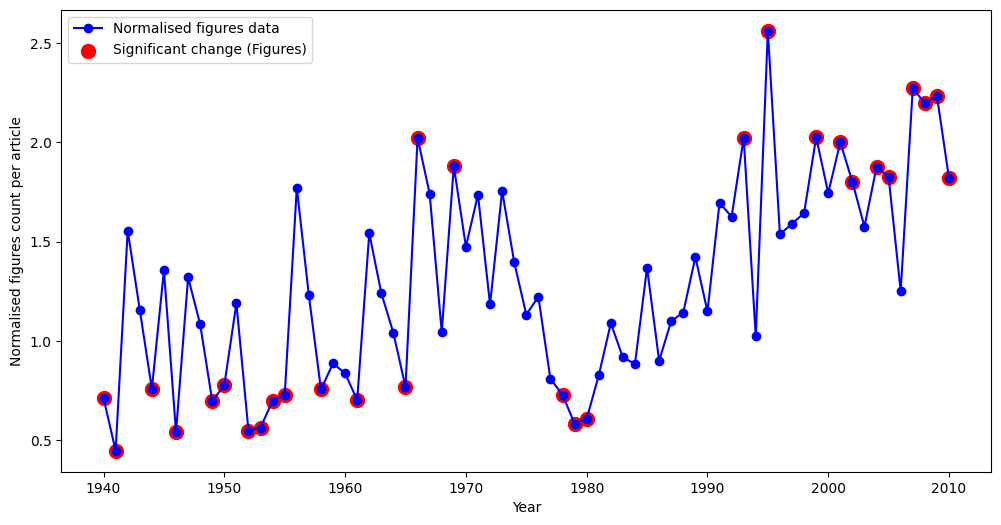

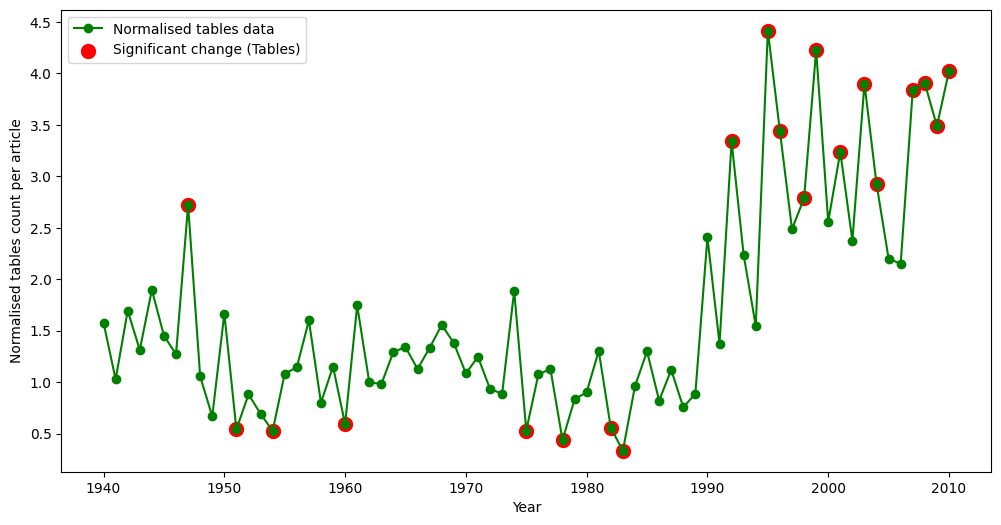

In [31]:
# Calculate the Z-scores for the proportions
qje_final['figures_zscore'] = zscore(qje_final['figures_normalised_by_articles'])
qje_final['tables_zscore'] = zscore(qje_final['tables_normalised_by_articles'])

# Set the threshold for significant years (e.g., Z-scores > 1)
threshold = 1

# Select significant years where Z-scores exceed the threshold for figures
significant_years_figures = qje_final[qje_final['figures_zscore'].abs() > threshold]

# Select significant years where Z-scores exceed the threshold for tables
significant_years_tables = qje_final[qje_final['tables_zscore'].abs() > threshold]

# Plotting the proportion of figures per page over the years
plt.figure(figsize=(12, 6))
plt.plot(qje_final['year'], qje_final['figures_normalised_by_articles'], marker='o', label='Normalised figures data', color='blue')

# Highlight the significant years for figures
plt.scatter(significant_years_figures['year'], significant_years_figures['figures_normalised_by_articles'], color='red', label='Significant change (Figures)', s=100)

plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()
plt.grid(False)
plt.show()

# Plotting the proportion of tables per page over the years
plt.figure(figsize=(12, 6))
plt.plot(qje_final['year'], qje_final['tables_normalised_by_articles'], marker='o', label='Normalised tables data', color='green')

# Highlight the significant years for tables
plt.scatter(significant_years_tables['year'], significant_years_tables['tables_normalised_by_articles'], color='red', label='Significant change (Tables)', s=100)
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.grid(False)
plt.show()

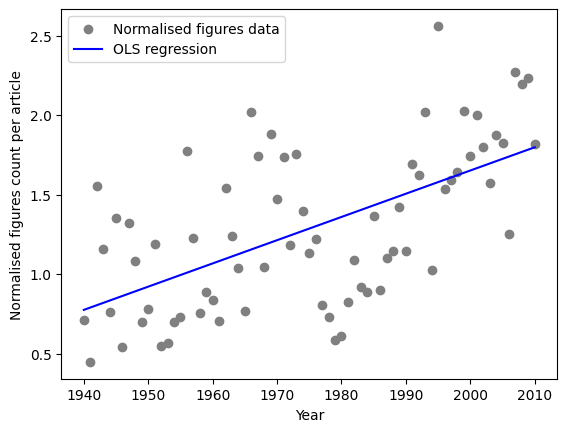

OLS Coefficient (Slope): 0.0146
OLS Intercept: 0.7748


In [32]:
# Figures
# Define your data with centered year
X = np.array(qje_final['year'] - 1940).reshape(-1, 1)  # Center year at 1940
y = np.array(qje_final['figures_normalised_by_articles'])

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)  

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, y, color='grey', label='Normalised figures data')

# Plot the OLS regression line
plt.plot(X +1940, y_pred_ols, color='blue', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()

# Display the plot
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [33]:
# Define your data
X = np.array(qje_final['year'] - 1940).reshape(-1, 1)  
y = np.array(qje_final['figures_normalised_by_articles'])   

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  # Adds a column of ones to include an intercept in the model

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the summary statistics
print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     37.96
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           4.25e-08
Time:                        11:45:36   Log-Likelihood:                -36.357
No. Observations:                  71   AIC:                             76.71
Df Residuals:                      69   BIC:                             81.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7748      0.096      8.053      0.0

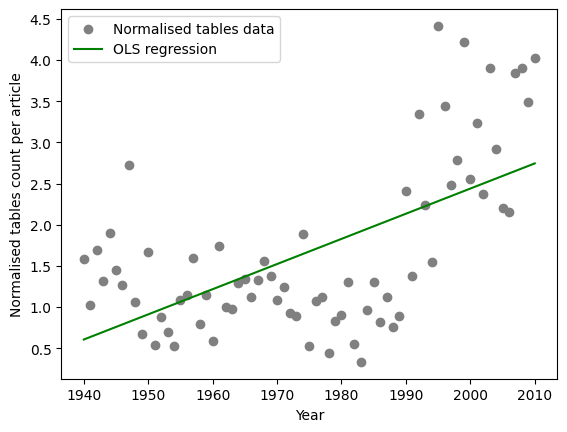

OLS Coefficient (Slope): 0.0306
OLS Intercept: 0.6055


In [34]:
# Tables
# Define your data
X = np.array(qje_final['year']- 1940).reshape(-1, 1)  
z = np.array(qje_final['tables_normalised_by_articles'])  

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, z)  

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, z, color='grey', label='Normalised tables data')

# Plot the OLS regression line
plt.plot(X + 1940, z_pred_ols, color='green', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [35]:
# Define your data
X = np.array(qje_final['year']- 1940).reshape(-1, 1)  
z = np.array(qje_final['tables_normalised_by_articles'])  

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(z, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = z - z_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(z, z_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     39.16
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           2.86e-08
Time:                        11:45:37   Log-Likelihood:                -87.631
No. Observations:                  71   AIC:                             179.3
Df Residuals:                      69   BIC:                             183.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6055      0.198      3.057      0.0

In [36]:
# RES
# Function to group data by 'id', sum numeric columns, and count unique pages
def group_data_by_id(df, id_col='id', sum_col=None, page_col=None, year_col='year'):
    agg_dict = {}
    if sum_col:
        agg_dict[sum_col] = 'sum'  # Summing the specified column (e.g., fg_count, tb_count)
    if page_col:
        agg_dict[page_col] = 'nunique'  # Counting unique pages
    if year_col:
        agg_dict[year_col] = 'first'  # Keeping the first year (assuming it is the same for all rows with the same 'id')

    return df.groupby(id_col).agg(agg_dict).reset_index()

# Function to convert a column to numeric and rename columns
def convert_and_rename(df, rename_dict):
    df.rename(columns=rename_dict, inplace=True)
    for col in rename_dict.values():
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    return df

# Step 1: Process df_ecta and group by 'id'
df_res_grouped = df_res.groupby('id').agg({'year': 'first', 'id': 'size'}).rename(columns={'id': 'num_pages'}).reset_index()

# Step 2: Process fg_count from ecta_figures (Sheet 1)
res_figures = convert_and_rename(res['fg1940_1970'], {'fg_count': 'fg_count'})
fg_count_grouped = group_data_by_id(res_figures, sum_col='fg_count')

# Step 3: Merge fg_count with df_ecta_grouped
res_merged = pd.merge(df_res_grouped, fg_count_grouped, on='id', how='left')
res_merged['fg_count'].fillna(0, inplace=True)

# Step 4: Process fg_count from Sheet 3 and merge with df_merged
res_combined = convert_and_rename(res['post1970'], {'ID': 'id', 'fg_count': 'fg_count'})
res_final = pd.merge(res_merged, res_combined[['id', 'fg_count']], on='id', how='left', suffixes=('_sheet1', '_sheet3'))
res_final['fg_count_sheet3'].fillna(0, inplace=True)
res_final['total_fg_count'] = res_final['fg_count_sheet1'] + res_final['fg_count_sheet3']

# Step 5: Process tb_count from ecta_tables (Sheet 2)
res_tables = convert_and_rename(res['tb1940_1970'], {'Answer': 'tb_count'})
tb_count_grouped = group_data_by_id(res_tables, sum_col='tb_count', page_col='page')
res_final = pd.merge(res_final, tb_count_grouped[['id', 'tb_count']], on='id', how='left')
res_final['tb_count'].fillna(0, inplace=True)

# Step 6: Process tb_count from Sheet 3 and merge with df_final_merged
res_combined = convert_and_rename(res['post1970'], {'tb_count': 'tb_count'})
res_final = pd.merge(res_final, res_combined[['id', 'tb_count']], on='id', how='left', suffixes=('_sheet2', '_sheet3'))
res_final['tb_count_sheet3'].fillna(0, inplace=True)
res_final['total_tb_count'] = res_final['tb_count_sheet2'] + res_final['tb_count_sheet3']

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/2571232024.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  res_merged['fg_count'].fillna(0, inplace=True)
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/2571232024.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [37]:
# Cleaning up the data set for before analysis
res_tbfg = res_final[['id', 'year_x', 'num_pages', 'total_fg_count', 'total_tb_count']].copy()

# Rename columns
res_tbfg.rename(columns={'year_x': 'year','total_fg_count':'figures','total_tb_count':'tables'}, inplace=True)

# Print 
print(res_tbfg.head())

# To get the length after filling in missing data
print("Number of rows in the final combined dataframe:", len(res_tbfg))

        id  year  num_pages  figures  tables
0  1556708  2002         19      0.0     0.0
1  1556709  2002         31      0.0     0.0
2  1556710  2002         23      2.0     4.0
3  1556711  2002         22      0.0     0.0
4  1556712  2002         35      5.0     8.0
Number of rows in the final combined dataframe: 2651


In [38]:
# RES 
# Step 1a: Calculate figures per page for each article
res_tbfg['figures_per_page'] = res_tbfg['figures'] / res_tbfg['num_pages']

# Step 2a: Normalize figures per page across articles per year
normalised_figures_per_year = res_tbfg.groupby('year').apply(
    lambda x: (x['figures_per_page'].sum()) / len(x)
).reset_index(name='normalised_figures_per_year')

# Step 3a: Normalize figures by the number of articles published per year
total_figures_per_year = res_tbfg.groupby('year')['figures'].sum().reset_index(name='total_figures')
articles_per_year = res_tbfg.groupby('year').size().reset_index(name='total_articles')
figures_data = pd.merge(total_figures_per_year, articles_per_year, on='year')
figures_data['figures_normalised_by_articles'] = figures_data['total_figures'] / figures_data['total_articles']

# Step 1b: Calculate tables per page for each article
res_tbfg['tables_per_page'] = res_tbfg['tables'] / res_tbfg['num_pages']

# Step 2b: Normalize tables per page across articles per year
normalised_tables_per_year = res_tbfg.groupby('year').apply(
    lambda x: (x['tables_per_page'].sum()) / len(x)
).reset_index(name='normalised_tables_per_year')

# Step 3b: Normalize tables by the number of articles published per year
total_tables_per_year = res_tbfg.groupby('year')['tables'].sum().reset_index(name='total_tables')
tables_data = pd.merge(total_tables_per_year, articles_per_year, on='year')
tables_data['tables_normalised_by_articles'] = tables_data['total_tables'] / tables_data['total_articles']

# Combine all data into a single dataframe
res_final = pd.merge(figures_data, tables_data, on=['year', 'total_articles'], how='outer')

# Merge normalized figures and tables per year
res_final = pd.merge(res_final, normalised_figures_per_year, on='year', how='outer')
res_final = pd.merge(res_final, normalised_tables_per_year, on='year', how='outer')

# Display the final combined dataframe
print(res_final.head())


   year  total_figures  total_articles  figures_normalised_by_articles  \
0  1940           22.0              21                        1.047619   
1  1941           17.0              18                        0.944444   
2  1942           14.0              12                        1.166667   
3  1943            7.0              11                        0.636364   
4  1944           10.0              16                        0.625000   

   total_tables  tables_normalised_by_articles  normalised_figures_per_year  \
0          14.0                       0.666667                     0.081262   
1          22.0                       1.222222                     0.133864   
2          36.0                       3.000000                     0.086669   
3          27.0                       2.454545                     0.130165   
4          42.0                       2.625000                     0.101637   

   normalised_tables_per_year  
0                    0.040693  
1               

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/3896304381.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_figures_per_year = res_tbfg.groupby('year').apply(
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/3896304381.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalised_tables_per_year = res_tbfg.groupby('year').apply(


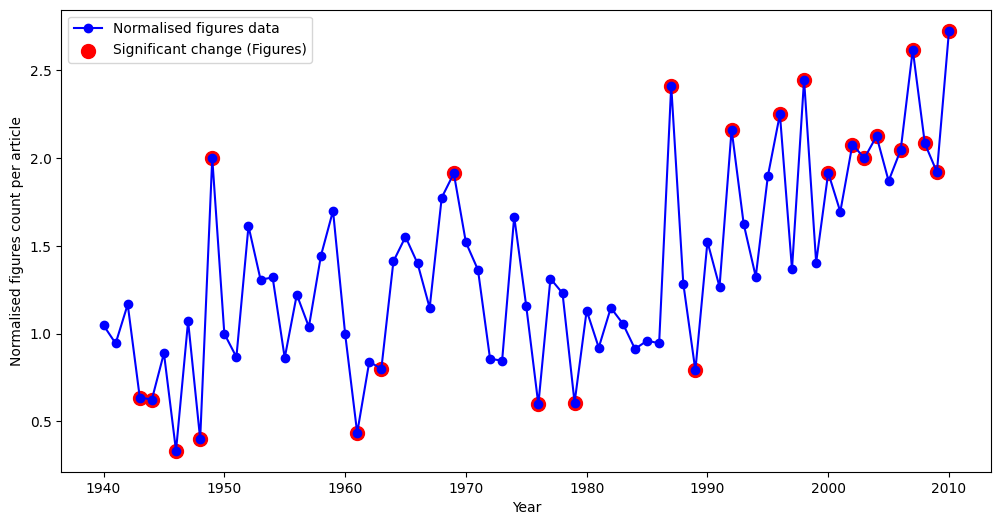

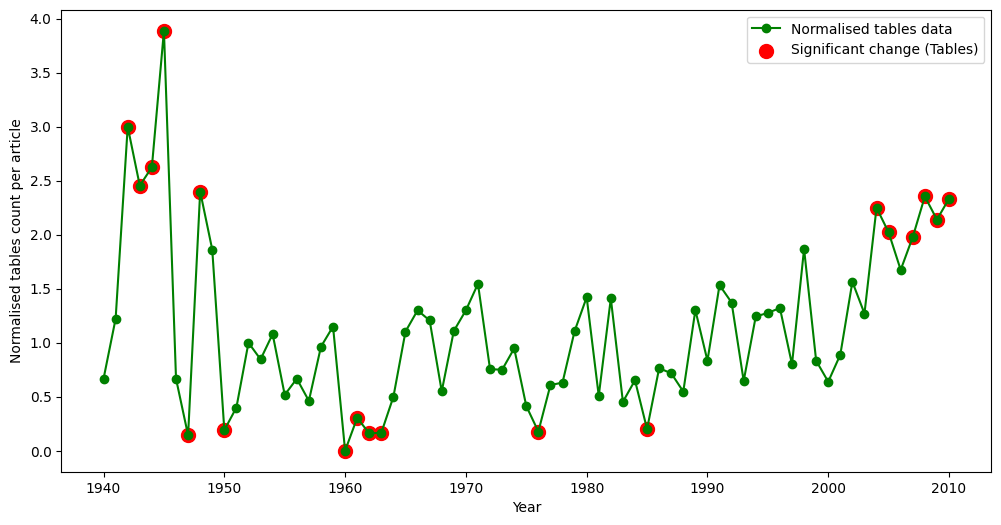

In [39]:
# Calculate the Z-scores for the proportions
res_final['figures_zscore'] = zscore(res_final['figures_normalised_by_articles'])
res_final['tables_zscore'] = zscore(res_final['tables_normalised_by_articles'])

# Set the threshold for significant years (e.g., Z-scores > 1)
threshold = 1

# Select significant years where Z-scores exceed the threshold for figures
significant_years_figures = res_final[res_final['figures_zscore'].abs() > threshold]

# Select significant years where Z-scores exceed the threshold for tables
significant_years_tables = res_final[res_final['tables_zscore'].abs() > threshold]

# Plotting the proportion of figures per page over the years
plt.figure(figsize=(12, 6))
plt.plot(res_final['year'], res_final['figures_normalised_by_articles'], marker='o', label='Normalised figures data', color='blue')

# Highlight the significant years for figures
plt.scatter(significant_years_figures['year'], significant_years_figures['figures_normalised_by_articles'], color='red', label='Significant change (Figures)', s=100)

plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()
plt.grid(False)
plt.show()

# Plotting the proportion of tables per page over the years
plt.figure(figsize=(12, 6))
plt.plot(res_final['year'], res_final['tables_normalised_by_articles'], marker='o', label='Normalised tables data', color='green')

# Highlight the significant years for tables
plt.scatter(significant_years_tables['year'], significant_years_tables['tables_normalised_by_articles'], color='red', label='Significant change (Tables)', s=100)
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.grid(False)
plt.show()

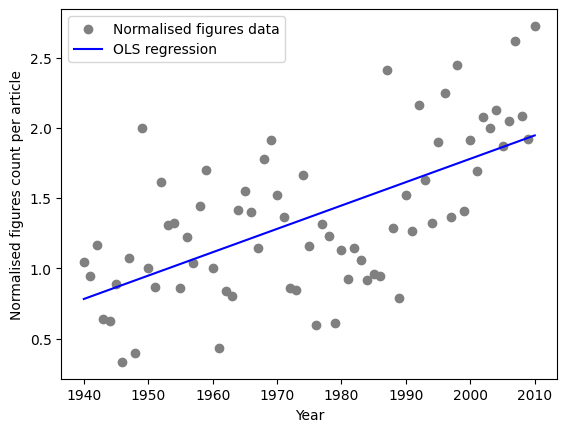

OLS Coefficient (Slope): 0.0166
OLS Intercept: 0.7814


In [40]:
# Figures
# Define your data with centered year
X = np.array(res_final['year'] - 1940).reshape(-1, 1)  # Center year at 1940
y = np.array(res_final['figures_normalised_by_articles'])

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, y)  

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, y, color='grey', label='Normalised figures data')

# Plot the OLS regression line
plt.plot(X +1940, y_pred_ols, color='blue', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised figures count per article')
plt.legend()

# Display the plot
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [41]:
# Define your data
X = np.array(res_final['year'] - 1940).reshape(-1, 1)  
y = np.array(res_final['figures_normalised_by_articles'])   

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  # Adds a column of ones to include an intercept in the model

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

# Print the summary statistics
print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     43.70
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           6.70e-09
Time:                        11:45:37   Log-Likelihood:                -40.566
No. Observations:                  71   AIC:                             85.13
Df Residuals:                      69   BIC:                             89.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7814      0.102      7.655      0.0

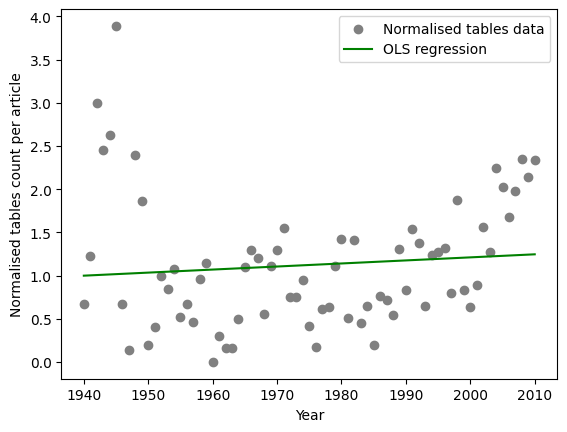

OLS Coefficient (Slope): 0.0035
OLS Intercept: 0.9983


In [42]:
# Tables
# Define your data
X = np.array(res_final['year']- 1940).reshape(-1, 1)  
z = np.array(res_final['tables_normalised_by_articles'])  

# Fit an OLS model
ols_model = LinearRegression()
ols_model.fit(X, z)  

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Plot the original data points
plt.scatter(X + 1940, z, color='grey', label='Normalised tables data')

# Plot the OLS regression line
plt.plot(X + 1940, z_pred_ols, color='green', label='OLS regression')

# Add titles and labels
plt.xlabel('Year')
plt.ylabel('Normalised tables count per article')
plt.legend()
plt.show()

# Print OLS coefficients
print(f"OLS Coefficient (Slope): {ols_model.coef_[0]:.4f}")
print(f"OLS Intercept: {ols_model.intercept_:.4f}")

In [43]:
# Define your data
X = np.array(res_final['year']- 1940).reshape(-1, 1)  
z = np.array(res_final['tables_normalised_by_articles'])  

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(z, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = z - z_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(z, z_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6476
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.424
Time:                        11:45:37   Log-Likelihood:                -80.013
No. Observations:                  71   AIC:                             164.0
Df Residuals:                      69   BIC:                             168.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9983      0.178      5.611      0.0

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/97169425.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size), random_state=42))  # Random sample
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46433/97169425.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size), random_state=42))  

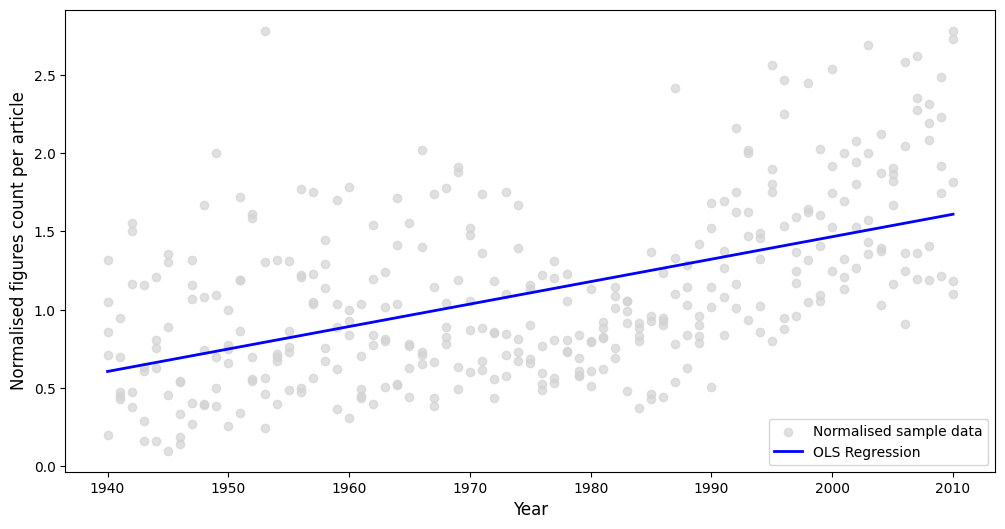

Intercept: 0.6060
Slope: 0.0143


In [44]:
# Example: Sampling and combining data
sample_size_per_year = 35
start_year, end_year = 1940, 2010

# Function to sample data from a single journal
def sample_journal_data(journal_data, sample_size, start_year, end_year):
    return (journal_data[journal_data['year'].between(start_year, end_year)]
            .groupby('year')
            .apply(lambda x: x.sample(min(len(x), sample_size), random_state=42))  # Random sample
            .reset_index(drop=True))

# Sampling for all journals
aer_sample = sample_journal_data(aer_final, sample_size_per_year, start_year, end_year)
ecta_sample = sample_journal_data(ecta_final, sample_size_per_year, start_year, end_year)
jpe_sample = sample_journal_data(jpe_final, sample_size_per_year, start_year, end_year)
qje_sample = sample_journal_data(qje_final, sample_size_per_year, start_year, end_year)
res_sample = sample_journal_data(res_final, sample_size_per_year, start_year, end_year)

# Combine all samples into one dataset
combined_data = pd.concat([aer_sample, ecta_sample, jpe_sample, qje_sample, res_sample])

# Select the year and proportion figures per page
combined_data = combined_data[['year', 'figures_normalised_by_articles','tables_normalised_by_articles']].dropna()

# Adjust year to be centred at 1940
combined_data['year_adj'] = combined_data['year'] - 1940

# Independent (X) and dependent (y) variables
X = combined_data['year_adj'].values.reshape(-1, 1)
y = combined_data['figures_normalised_by_articles']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate predictions for the regression line
year_range = np.arange(start_year, end_year + 1) - 1940
predicted_values = model.predict(year_range.reshape(-1, 1))

# Plot the data and regression line
plt.figure(figsize=(12, 6))

# Scatter plot for sampled data
plt.scatter(combined_data['year'], combined_data['figures_normalised_by_articles'], 
            color='lightgrey', alpha=0.7, label='Normalised sample data')

# Plot the regression line
plt.plot(year_range + 1940, predicted_values, color='blue', linewidth=2, label='OLS Regression')

# Add labels, title, and legend
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalised figures count per article', fontsize=12)
plt.legend(fontsize=10)
plt.grid(False)
plt.show()

# Print regression coefficients
print(f"Intercept: {model.intercept_:.4f}")
print(f"Slope: {model.coef_[0]:.4f}")


In [45]:
# Independent (X) and dependent (y) variables
X = combined_data['year_adj'].values.reshape(-1, 1)
y = combined_data['figures_normalised_by_articles']

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                                  OLS Regression Results                                  
Dep. Variable:     figures_normalised_by_articles   R-squared:                       0.279
Model:                                        OLS   Adj. R-squared:                  0.277
Method:                             Least Squares   F-statistic:                     136.5
Date:                            Thu, 05 Dec 2024   Prob (F-statistic):           7.08e-27
Time:                                    11:45:37   Log-Likelihood:                -237.69
No. Observations:                             355   AIC:                             479.4
Df Residuals:                                 353   BIC:                             487.1
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

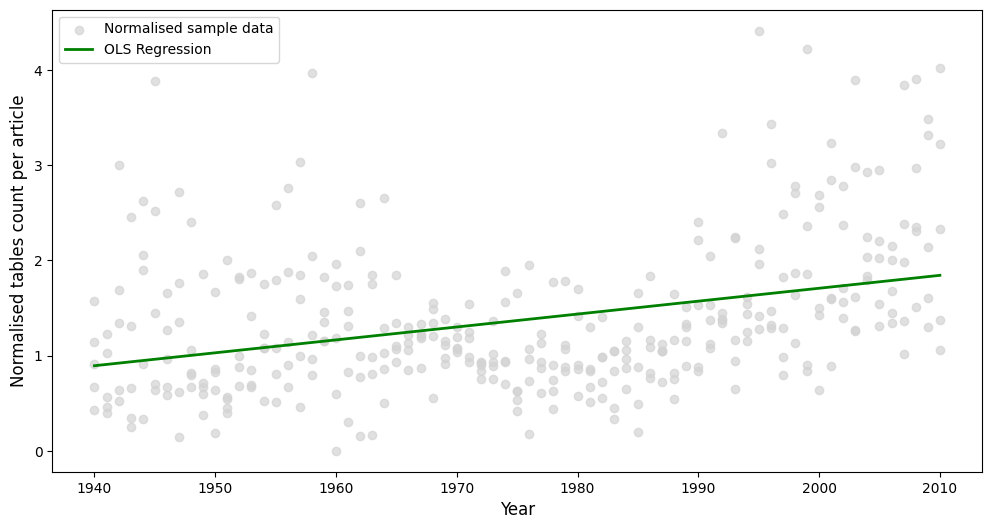

Intercept: 0.8935
Slope: 0.0136


In [46]:
# Tables 
# Independent (X) and dependent (y) variables
X = combined_data['year_adj'].values.reshape(-1, 1)
z = combined_data['tables_normalised_by_articles']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, z)

# Generate predictions for the regression line
year_range = np.arange(start_year, end_year + 1) - 1940
predicted_values = model.predict(year_range.reshape(-1, 1))

# Plot the data and regression line
plt.figure(figsize=(12, 6))

# Scatter plot for sampled data
plt.scatter(combined_data['year'], combined_data['tables_normalised_by_articles'], 
            color='lightgrey', alpha=0.7, label='Normalised sample data')

# Plot the regression line
plt.plot(year_range + 1940, predicted_values, color='green', linewidth=2, label='OLS Regression')

# Add labels, title, and legend
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalised tables count per article', fontsize=12)
plt.legend(fontsize=10)
plt.grid(False)
plt.show()

# Print regression coefficients
print(f"Intercept: {model.intercept_:.4f}")
print(f"Slope: {model.coef_[0]:.4f}")


In [47]:

# Independent (X) and dependent (y) variables
X = combined_data['year_adj'].values.reshape(-1, 1)
z = combined_data['tables_normalised_by_articles']

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(z, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
z_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = z - z_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(z, z_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                                  OLS Regression Results                                 
Dep. Variable:     tables_normalised_by_articles   R-squared:                       0.126
Model:                                       OLS   Adj. R-squared:                  0.123
Method:                            Least Squares   F-statistic:                     50.76
Date:                           Thu, 05 Dec 2024   Prob (F-statistic):           5.89e-12
Time:                                   11:45:37   Log-Likelihood:                -393.68
No. Observations:                            355   AIC:                             791.4
Df Residuals:                                353   BIC:                             799.1
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

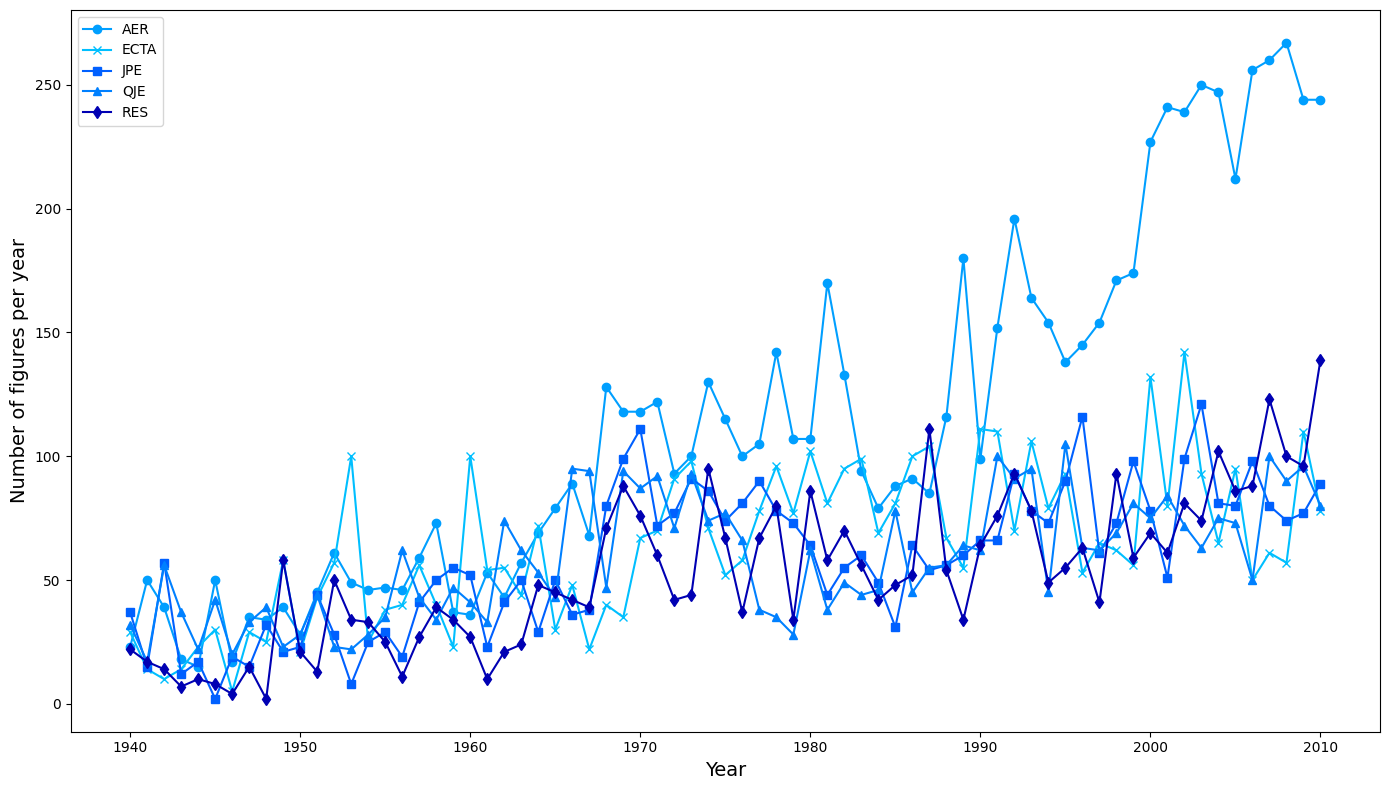

In [63]:
# Number of figures per year before normalisation
# Extract year and figures for each journal
aer_figures = aer_tbfg.groupby('year')['figures'].sum()
ecta_figures = ecta_tbfg.groupby('year')['figures'].sum()
jpe_figures = jpe_tbfg.groupby('year')['figures'].sum()
qje_figures = qje_tbfg.groupby('year')['figures'].sum()
res_figures = res_tbfg.groupby('year')['figures'].sum()

# Combine all journals into a single dataframe
data = {
    'AER': aer_figures,
    'ECTA': ecta_figures,
    'JPE': jpe_figures,
    'QJE': qje_figures,
    'RES': res_figures
}

# Create a pivoted dataframe for plotting
pivoted = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(14, 8))

plt.plot(pivoted.index, pivoted['AER'], label='AER', marker='o', color='#009fff')
plt.plot(pivoted.index, pivoted['ECTA'], label='ECTA', marker='x', color='#00bfff')
plt.plot(pivoted.index, pivoted['JPE'], label='JPE', marker='s', color='#0060ff')
plt.plot(pivoted.index, pivoted['QJE'], label='QJE', marker='^', color='#0080ff')
plt.plot(pivoted.index, pivoted['RES'], label='RES', marker='d', color='#0000b3')

# Customize the graph
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of figures per year', fontsize=14)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
# Calculate trend 
# Define a function to calculate trend slope
def calculate_trend(data):
    years = data.index.values
    figures = data.values
    slope, intercept, r_value, p_value, std_err = linregress(years, figures)
    return slope, p_value

# Calculate trends for each journal
aer_slope, aer_p_value = calculate_trend(aer_figures)
ecta_slope, ecta_p_value = calculate_trend(ecta_figures)
jpe_slope, jpe_p_value = calculate_trend(jpe_figures)
qje_slope, qje_p_value = calculate_trend(qje_figures)
res_slope, res_p_value = calculate_trend(res_figures)

# Print results
print(f"AER Trend: Slope={aer_slope:.2f}, p-value={aer_p_value:.2e}")
print(f"ECTA Trend: Slope={ecta_slope:.2f}, p-value={ecta_p_value:.2e}")
print(f"JPE Trend: Slope={jpe_slope:.2f}, p-value={jpe_p_value:.2e}")
print(f"QJE Trend: Slope={qje_slope:.2f}, p-value={qje_p_value:.2e}")
print(f"RES Trend: Slope={res_slope:.2f}, p-value={res_p_value:.2e}")


AER Trend: Slope=3.18, p-value=1.07e-28
ECTA Trend: Slope=0.98, p-value=5.99e-10
JPE Trend: Slope=1.01, p-value=2.92e-13
QJE Trend: Slope=0.73, p-value=6.35e-09
RES Trend: Slope=1.18, p-value=3.65e-16


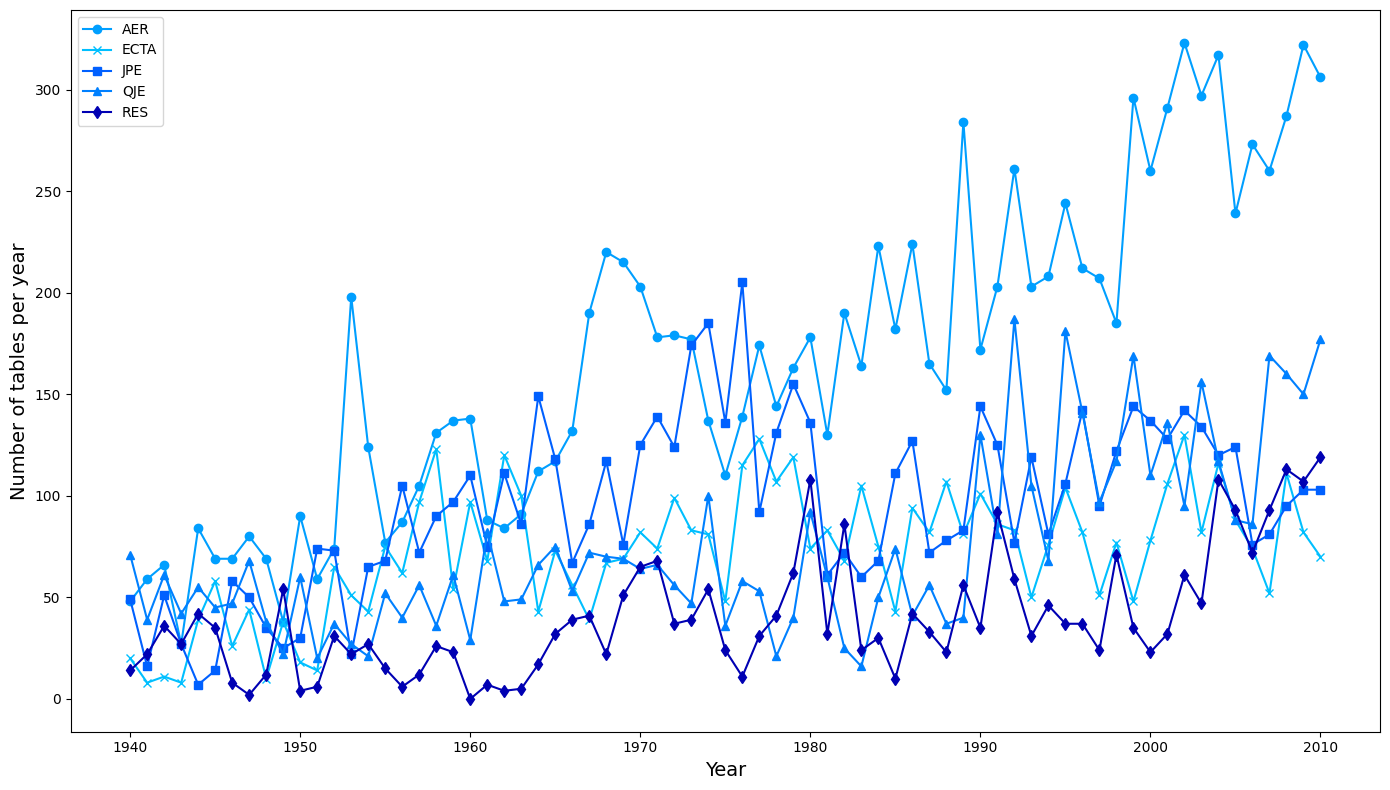

In [62]:
# Number of figures per year before normalisation
# Extract year and figures for each journal
aer_tables = aer_tbfg.groupby('year')['tables'].sum()
ecta_tables = ecta_tbfg.groupby('year')['tables'].sum()
jpe_tables = jpe_tbfg.groupby('year')['tables'].sum()
qje_tables = qje_tbfg.groupby('year')['tables'].sum()
res_tables = res_tbfg.groupby('year')['tables'].sum()

# Combine all journals into a single dataframe
data = {
    'AER': aer_tables,
    'ECTA': ecta_tables,
    'JPE': jpe_tables,
    'QJE': qje_tables,
    'RES': res_tables
}

# Create a pivoted dataframe for plotting
pivoted = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(14, 8))

plt.plot(pivoted.index, pivoted['AER'], label='AER', marker='o', color='#009fff')
plt.plot(pivoted.index, pivoted['ECTA'], label='ECTA', marker='x', color='#00bfff')
plt.plot(pivoted.index, pivoted['JPE'], label='JPE', marker='s', color='#0060ff')
plt.plot(pivoted.index, pivoted['QJE'], label='QJE', marker='^', color='#0080ff')
plt.plot(pivoted.index, pivoted['RES'], label='RES', marker='d', color='#0000b3')

# Customize the graph
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of tables per year', fontsize=14)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
# Calculate trend
# Define a function to calculate trend slope
def calculate_trend(data):
    years = data.index.values
    tables = data.values
    slope, intercept, r_value, p_value, std_err = linregress(years, tables)
    return slope, p_value

# Calculate trends for each journal
aer_slope, aer_p_value = calculate_trend(aer_tables)
ecta_slope, ecta_p_value = calculate_trend(ecta_tables)
jpe_slope, jpe_p_value = calculate_trend(jpe_tables)
qje_slope, qje_p_value = calculate_trend(qje_tables)
res_slope, res_p_value = calculate_trend(res_tables)

# Print results
print(f"AER Trend: Slope={aer_slope:.2f}, p-value={aer_p_value:.2e}")
print(f"ECTA Trend: Slope={ecta_slope:.2f}, p-value={ecta_p_value:.2e}")
print(f"JPE Trend: Slope={jpe_slope:.2f}, p-value={jpe_p_value:.2e}")
print(f"QJE Trend: Slope={qje_slope:.2f}, p-value={qje_p_value:.2e}")
print(f"RES Trend: Slope={res_slope:.2f}, p-value={res_p_value:.2e}")

AER Trend: Slope=3.42, p-value=8.77e-26
ECTA Trend: Slope=0.81, p-value=1.47e-06
JPE Trend: Slope=1.09, p-value=1.55e-06
QJE Trend: Slope=1.45, p-value=6.60e-11
RES Trend: Slope=0.89, p-value=9.62e-09
